In [254]:
import math
import random
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.distributions import Dirichlet
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque

In [255]:
# Define the 10 assets (tickers) for the portfolio
# tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "BA", "NFLX", "NVDA", "META", "SBUX"]

# tickers = ["AAPL", "MSFT", "GOOGL", "SBUX", "TSLA"]
tickers = ["GME", "AMC", "SPCE", "NVAX", "NOK"]
# tickers = ["GME", "AMC", "BB", "NVAX", "NOK"]
# tickers = ["GME", "AMC", "HMC", "NVAX", "NOK"]
# Date range for historical data
start_date = "2017-01-01"
end_date   = "2023-12-31"

# Try to load price data from a local CSV, otherwise download using yfinance
data_file = "prices.csv"
try:
    prices_df = pd.read_csv(data_file, index_col=0, parse_dates=True)
    print("Loaded data from", data_file)
except FileNotFoundError:
    print("Downloading price data for tickers:", tickers)
    df = yf.download(tickers, start=start_date, end=end_date, interval="1d")
    # Extract the 'Close' prices from the MultiIndex DataFrame
    prices_df = df.xs('Close', axis=1, level='Price')
    prices_df.dropna(inplace=True)
    prices_df.to_csv(data_file)
    print("Data downloaded and saved to", data_file)

# Split data into training (first 4 years) and testing (last year)
full_train_df = prices_df[prices_df.index < "2023-01-01"]
test_df  = prices_df[prices_df.index >= "2023-01-01"]
full_train_prices = full_train_df.values  # shape: [train_days, 5]
test_prices  = test_df.values   # shape: [test_days, 5]
num_assets = full_train_prices.shape[1]
print(f"Training days: {full_train_prices.shape[0]}, Testing days: {test_prices.shape[0]}")

# Further split full training into training and validation (80/20)
split_index = int(0.8 * full_train_prices.shape[0])
train_prices = full_train_prices[:split_index]
val_prices   = full_train_prices[split_index:]

Loaded data from prices.csv
Training days: 1323, Testing days: 250


In [256]:
# Compute technical indicators: moving average ratio and volatility
def get_market_indicators(price_array, t, window=10):
    """
    Compute technical indicators for each asset at time index t:
      - Moving Average Ratio: price[t] / (mean price over previous 'window' days)
      - Volatility: std of daily returns over 'window' days, normalized by current price
    If insufficient history (t < window), default to 1.0 for MA ratio and 0.0 for volatility.
    Returns a list of length 2*num_assets.
    """
    indicators = []
    for i in range(num_assets):
        if t < window:
            ma_ratio = 1.0
            vol = 0.0
        else:
            window_prices = price_array[t-window+1 : t+1, i]  # last 'window' days up to t
            ma = window_prices.mean()
            ma_ratio = price_array[t, i] / (ma + 1e-6)
            # Compute daily returns over the window
            rets = np.diff(window_prices) / (window_prices[:-1] + 1e-6)
            vol = rets.std() / (price_array[t, i] + 1e-6)
        indicators.append(ma_ratio)
        indicators.append(vol)
    return indicators

# Construct state vector from current day and allocation
def get_state(price_array, t, alloc):
    """
    Build the state vector at time t given current allocation (fractions) and price data.
    - alloc: list of length N+1 (including cash) with current portfolio fractions that sum to 1.
    - price_array: numpy array of prices [days x N].
    - t: current time index (0-based).
    Returns: numpy array of shape (state_dim,).
    """
    # Ensure allocation fractions (already between 0 and 1 and sum to 1)
    alloc_frac = alloc
    indicators = get_market_indicators(price_array, t)
    state_vec = np.array(list(alloc_frac) + indicators, dtype=np.float32)
    return state_vec

In [257]:
# Reward shaping class to incorporate rolling Sharpe and drawdown penalty
class SharpeRewardShaper:
    def __init__(self, window=30, eps=1e-6):
        self.window = window
        self.eps = eps
        self.recent_rewards = []
        self.max_portfolio_val = 0.0

    def reset(self):
        self.recent_rewards = []
        self.max_portfolio_val = 0.0

    def shape(self, raw_reward, current_portfolio_val):
        # Update rolling window of rewards
        self.recent_rewards.append(raw_reward)
        if len(self.recent_rewards) > self.window:
            self.recent_rewards.pop(0)
        # Compute rolling Sharpe ratio (mean/std of recent rewards)
        avg = np.mean(self.recent_rewards)
        std = np.std(self.recent_rewards) + self.eps
        sharpe = avg / std
        # Update max portfolio value seen so far
        if current_portfolio_val > self.max_portfolio_val:
            self.max_portfolio_val = current_portfolio_val
        # Drawdown: relative drop from peak value
        drawdown = (self.max_portfolio_val - current_portfolio_val) / (self.max_portfolio_val + self.eps)
        # Penalties for drawdown and volatility
        drawdown_penalty = 0.5 * drawdown
        vol_penalty = 0.5 * std
        # Compute shaped reward
        shaped_reward = sharpe - drawdown_penalty - vol_penalty
        return shaped_reward

# Compute n-step portfolio log return as raw reward
def compute_n_step_log_return(price_array, t, n_step, weights):
    """
    Compute log return from day t to t+n_step using given portfolio weights.
    - price_array: prices matrix
    - t: current day index
    - n_step: horizon (if beyond data end, use last available day)
    - weights: allocation fractions for assets and cash (length N+1, sum=1)
    Returns: log(growth_factor)
    """
    last_idx = min(t + n_step, price_array.shape[0] - 1)
    growth_factor = 0.0
    # weights includes cash as last element
    for i in range(len(weights)):
        if i == num_assets:  # cash index
            ratio = 1.0
        else:
            # price ratio from t to last_idx
            ratio = price_array[last_idx, i] / (price_array[t, i] + 1e-6)
        growth_factor += weights[i] * ratio
    return math.log(growth_factor + 1e-6)

In [258]:
# Neural network for PPO actor-critic
class ActorCritic(nn.Module):
    def __init__(self, state_dim, asset_count):
        super(ActorCritic, self).__init__()
        self.asset_count = asset_count  # number of assets (not including cash)
        # Define common backbone
        self.fc1 = nn.Linear(state_dim, 128)
        self.ln1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 256)
        self.ln2 = nn.LayerNorm(256)
        self.fc3 = nn.Linear(256, 128)
        self.ln3 = nn.LayerNorm(128)
        # Policy head
        self.policy_head = nn.Linear(128, asset_count + 1)  # outputs alpha parameters for each asset + cash
        # Value head
        self.value_head = nn.Linear(128, 1)
        
        # Initialize weights (optional: xavier for faster convergence)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)
    
    def forward(self, state):
        """Forward pass: returns Dirichlet concentration parameters and value."""
        x = torch.relu(self.ln1(self.fc1(state)))
        x = torch.relu(self.ln2(self.fc2(x)))
        x = torch.relu(self.ln3(self.fc3(x)))
        # Softplus to ensure positivity of alpha parameters
        alpha = F.softplus(self.policy_head(x)) + 1e-3  # small epsilon to avoid zeros
        value = self.value_head(x)
        return alpha, value

In [259]:
# Hyperparameters
num_episodes = 500         # how many training episodes (iterations over the training period)
gamma = 0.98               # discount factor
lambda_gae = 0.95          # GAE lambda
clip_epsilon = 0.3         # PPO clipping parameter
policy_lr = 5e-4           # learning rate
value_lr = 5e-4            # (could use single optimizer for both)
ppo_epochs = 10             # number of update epochs per batch
batch_size = 512            # mini-batch size for PPO updates
n_step = 5                 # n-step return horizon for reward calculation

In [260]:

state_dim = (num_assets + 1) + 2 * num_assets  # length of state vector
model = ActorCritic(state_dim, num_assets)
optimizer = optim.Adam(model.parameters(), lr=policy_lr)
shaper = SharpeRewardShaper(window=30)

In [261]:
def evaluate_on_validation_ppo(val_prices, model, initial_alloc, n_step):
    """
    Run a *deterministic* allocation policy (mean of Dirichlet) over val_prices.
    Returns log(final portfolio value).
    """
    model.eval()
    alloc = initial_alloc.copy()
    portfolio = 1.0
    days = val_prices.shape[0]

    with torch.no_grad():
        for t in range(days - 1):
            state_vec = get_state(val_prices, t, alloc)
            state_t   = torch.from_numpy(state_vec).unsqueeze(0).float()
            alpha, _  = model(state_t)
            alpha = alpha.squeeze(0).cpu().numpy()
            # deterministic: use mean of Dirichlet
            alloc = alpha / alpha.sum()
            # one‑step growth (for simplicity)
            growth = 0.0
            for i in range(num_assets+1):
                if i == num_assets:
                    ratio = 1.0
                else:
                    ratio = val_prices[t+1,i] / (val_prices[t,i] + 1e-6)
                growth += alloc[i]*ratio
            portfolio *= growth

    return math.log(portfolio + 1e-6)



In [262]:
def train_agent_ppo(episodes=200,
                    ppo_epochs=5,
                    batch_size=64,
                    policy_lr=5e-4,
                    lambda_gae=0.95,
                    clip_epsilon=0.2,
                    val_interval=10,
                    max_patience=5,
                    initial_alloc=None):
    """
    Train one PPO agent on train_prices, early‑stopping on val_prices.
    Returns the *best* model (state restored to best val performance).
    """
    # 1) build model, optimizer, reward shaper
    model     = ActorCritic(state_dim, num_assets).float()
    optimizer = torch.optim.Adam(model.parameters(), lr=policy_lr)
    shaper    = SharpeRewardShaper(window=30)

    best_val_reward = -float("inf")
    patience       = 0
    best_state     = None

    for ep in range(1, episodes+1):
        # ---- collect one trajectory ----
        portfolio = 1.0
        alloc     = initial_alloc.copy()
        shaper.reset()

        states, actions, old_logps, rewards, values, dones = [], [], [], [], [], []
        t = 0
        days = train_prices.shape[0]
        while t < days - 1:
            s_vec = get_state(train_prices, t, alloc)
            s_t   = torch.from_numpy(s_vec).unsqueeze(0).float()
            alpha, v = model(s_t)
            alpha = alpha.squeeze(0)
            v     = v.squeeze(0)

            dist = Dirichlet(alpha)
            a_s  = dist.sample()
            alloc = a_s.cpu().numpy()
            logp = dist.log_prob(a_s).item()

            # compute shaped reward
            raw_r = compute_n_step_log_return(train_prices, t, n_step, alloc)
            portfolio *= math.exp(raw_r)
            r = shaper.shape(raw_r, portfolio)

            done = (t >= days - n_step - 2)

            # store
            states.append(s_vec)
            actions.append(alloc)
            old_logps.append(logp)
            rewards.append(r)
            values.append(v.item())
            dones.append(done)

            t += 1
            if done:
                break

        # ---- compute GAE & returns ----
        T = len(rewards)
        advantages = np.zeros(T, dtype=np.float32)
        returns    = np.zeros(T, dtype=np.float32)
        next_v     = 0.0
        if not dones[-1]:
            s_vec = get_state(train_prices, t, alloc)
            _, nv = model(torch.from_numpy(s_vec).unsqueeze(0).float())
            next_v = nv.item()
        gae = 0.0
        for i in reversed(range(T)):
            mask  = 0.0 if dones[i] else 1.0
            delta = rewards[i] + gamma * next_v * mask - values[i]
            gae   = delta + gamma * lambda_gae * mask * gae
            advantages[i] = gae
            next_v = values[i]
        returns = advantages + np.array(values, dtype=np.float32)
        # normalize adv
        adv_mean, adv_std = advantages.mean(), advantages.std()+1e-8
        advantages = (advantages - adv_mean) / adv_std

        # to tensors
        S = torch.tensor(states, dtype=torch.float32)
        A = torch.tensor(actions, dtype=torch.float32)
        LP= torch.tensor(old_logps, dtype=torch.float32)
        ADV= torch.tensor(advantages, dtype=torch.float32)
        RET= torch.tensor(returns, dtype=torch.float32)

        # ---- PPO updates ----
        for _ in range(ppo_epochs):
            idxs = np.arange(T)
            np.random.shuffle(idxs)
            for start in range(0, T, batch_size):
                batch = idxs[start:start+batch_size]
                sb, ab, lp_old, adv_b, ret_b = S[batch], A[batch], LP[batch], ADV[batch], RET[batch]

                alpha_b, v_b = model(sb)
                dist_b        = Dirichlet(alpha_b)
                lp_new        = dist_b.log_prob(ab)

                ratio = (lp_new - lp_old).exp()
                s1    = ratio * adv_b
                s2    = torch.clamp(ratio, 1-clip_epsilon, 1+clip_epsilon) * adv_b
                loss_a = -torch.min(s1, s2).mean()
                loss_c = 0.5 * F.mse_loss(v_b.squeeze(1), ret_b)
                loss_e = -0.001 * dist_b.entropy().mean()

                loss = loss_a + loss_c + loss_e
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # ---- early stopping check on validation ----
        if ep % val_interval == 0:
            val_r = evaluate_on_validation_ppo(val_prices, model, initial_alloc, n_step)
            print(f"[PPO Ep {ep}] val={val_r:.4f}  best={best_val_reward:.4f}")
            if val_r > best_val_reward:
                best_val_reward = val_r
                patience        = 0
                best_state      = model.state_dict()
                print("  ↳ new best! checkpointing model")
            else:
                patience += 1
                print(f"  ↳ no improvement ({patience}/{max_patience})")
                if patience >= max_patience:
                    print(f"Early stopping at ep {ep}")
                    break

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    return model


In [263]:
def run_experiments_ppo(n_experiments=5, **train_params):
    """
    Repeat PPO training multiple times; each run returns its best model.
    """
    models = []
    for i in range(n_experiments):
        print(f"\n=== PPO Experiment {i+1}/{n_experiments} ===")
        m = train_agent_ppo(**train_params)
        models.append(m)
    return models



In [264]:
initial_alloc =  [.62, .1, .1, .35, .1, 0]  # initial allocation (5 assets + cash)
ppo_models = run_experiments_ppo(
    n_experiments=10,
    episodes=200,
    ppo_epochs=10,
    batch_size=512,
    policy_lr=5e-4,
    lambda_gae=0.95,
    clip_epsilon=0.2,
    val_interval=10,
    max_patience=5,
    initial_alloc=initial_alloc
)


=== PPO Experiment 1/10 ===
[PPO Ep 10] val=-0.8550  best=-inf
  ↳ new best! checkpointing model
[PPO Ep 20] val=-0.9768  best=-0.8550
  ↳ no improvement (1/5)
[PPO Ep 30] val=-1.0470  best=-0.8550
  ↳ no improvement (2/5)
[PPO Ep 40] val=-1.1255  best=-0.8550
  ↳ no improvement (3/5)
[PPO Ep 50] val=-1.3133  best=-0.8550
  ↳ no improvement (4/5)
[PPO Ep 60] val=-1.2371  best=-0.8550
  ↳ no improvement (5/5)
Early stopping at ep 60

=== PPO Experiment 2/10 ===
[PPO Ep 10] val=-1.1370  best=-inf
  ↳ new best! checkpointing model
[PPO Ep 20] val=-1.1810  best=-1.1370
  ↳ no improvement (1/5)
[PPO Ep 30] val=-1.1075  best=-1.1370
  ↳ new best! checkpointing model
[PPO Ep 40] val=-1.0147  best=-1.1075
  ↳ new best! checkpointing model
[PPO Ep 50] val=-0.9223  best=-1.0147
  ↳ new best! checkpointing model
[PPO Ep 60] val=-0.8688  best=-0.9223
  ↳ new best! checkpointing model
[PPO Ep 70] val=-0.8036  best=-0.8688
  ↳ new best! checkpointing model
[PPO Ep 80] val=-0.8208  best=-0.8036
  ↳ 

In [265]:
# for ep in range(1, num_episodes+1):
#     # Reset environment state for a new episode
#     portfolio_value = 1.0
#     # Start with 100% cash (allocation vector = [0,...,0,1])
#     current_alloc = np.zeros(num_assets+1, dtype=np.float32)
#     current_alloc[-1] = 1.0  # all cash initially
#     shaper.reset()
    
#     # Storage for trajectory
#     states = []
#     actions = []
#     log_probs = []
#     rewards = []
#     values = []
#     dones = []
    
#     days = train_prices.shape[0]
#     t = 0
#     while t < days - 1:
#         # Get state and model outputs
#         state_vec = get_state(train_prices, t, current_alloc)
#         state_tensor = torch.from_numpy(state_vec).unsqueeze(0).float()
#         alpha, value = model(state_tensor)
#         alpha = alpha.squeeze(0)
#         value = value.squeeze(0)
        
#         # Sample action (allocation) from Dirichlet policy
#         dist = Dirichlet(alpha)
#         action_sample = dist.sample()              # sample a allocation vector (length N+1)
#         action_weights = action_sample.numpy()     # numpy vector of allocations summing to 1
#         # Log probability of this action
#         log_prob = dist.log_prob(action_sample).item()
        
#         # Apply the action (rebalance portfolio)
#         new_alloc = action_weights  # since action is directly the new allocation fractions
        
#         # Compute raw n-step reward
#         raw_reward = compute_n_step_log_return(train_prices, t, n_step, new_alloc)
#         # Update portfolio value based on realized growth (exponentiate log return)
#         portfolio_value *= math.exp(raw_reward)
#         # Shape the reward
#         shaped_reward = shaper.shape(raw_reward, portfolio_value)
        
#         # Determine done flag (end of episode if we near end of data)
#         done = (t >= days - n_step - 2)  # end early to avoid incomplete n-step window
        
#         # Store transition
#         states.append(state_vec)
#         actions.append(action_sample.numpy())
#         log_probs.append(log_prob)
#         rewards.append(shaped_reward)
#         values.append(value.item())
#         dones.append(done)
        
#         # Update current allocation for next step (for state calculation at t+1):
#         # Here we set current_alloc equal to the new allocation we just applied.
#         current_alloc = new_alloc
        
#         # Move to next day (advance by 1 day)
#         t += 1
#         if done:
#             break
    
#     # Convert trajectory to tensors
#     states_t = torch.tensor(states, dtype=torch.float32)
#     actions_t = torch.tensor(actions, dtype=torch.float32)
#     old_log_probs_t = torch.tensor(log_probs, dtype=torch.float32)
#     rewards_np = np.array(rewards, dtype=np.float32)
#     values_np = np.array(values, dtype=np.float32)
#     dones_np = np.array(dones, dtype=np.bool_)
    
#     # Compute advantages using GAE
#     advantages = []
#     gae = 0.0
#     # If episode ended naturally, we consider last next value = 0; else if not done, we bootstrap from last value
#     next_value = 0.0
#     if not dones_np[-1]:
#         # If we didn't reach done (should typically reach done at end of train period), bootstrap with last value prediction
#         next_state_vec = get_state(train_prices, t, current_alloc)
#         next_state_tensor = torch.from_numpy(next_state_vec).unsqueeze(0).float()
#         _, next_val = model(next_state_tensor)
#         next_value = next_val.item()
#     for step in reversed(range(len(rewards_np))):
#         mask = 0.0 if dones_np[step] else 1.0
#         delta = rewards_np[step] + gamma * (next_value * mask) - values_np[step]
#         gae = delta + gamma * lambda_gae * mask * gae
#         advantages.insert(0, gae)
#         next_value = values_np[step]
#     advantages = np.array(advantages, dtype=np.float32)
#     # Compute discounted returns
#     returns = values_np + advantages  # since advantage = return - value by construction
    
#     # Normalize advantages
#     adv_mean = advantages.mean()
#     adv_std = advantages.std() + 1e-8
#     advantages = (advantages - adv_mean) / adv_std
    
#     # Convert to tensors
#     advantages_t = torch.tensor(advantages, dtype=torch.float32)
#     returns_t = torch.tensor(returns, dtype=torch.float32)
    
#     # PPO policy updates
#     for _ in range(ppo_epochs):
#         # Shuffle indices for mini-batches
#         indices = np.arange(len(states))
#         np.random.shuffle(indices)
#         for start in range(0, len(states), batch_size):
#             end = start + batch_size
#             batch_idx = indices[start:end]
            
#             batch_states = states_t[batch_idx]
#             batch_actions = actions_t[batch_idx]
#             batch_old_log_probs = old_log_probs_t[batch_idx]
#             batch_advantages = advantages_t[batch_idx]
#             batch_returns = returns_t[batch_idx]
            
#             # Get current policy outputs for batch
#             alpha_batch, value_batch = model(batch_states)
#             # Create distribution and calculate log probs of *chosen actions* in this batch
#             dist_batch = Dirichlet(alpha_batch)
#             # We need log_prob of the *actions that were actually taken* (stored in batch_actions)
#             # Dirichlet.log_prob expects valid probability vectors as input (which our actions are)
#             new_log_probs = dist_batch.log_prob(batch_actions)
#             # Evaluate probability ratio
#             ratio = torch.exp(new_log_probs - batch_old_log_probs)
#             # Compute surrogate losses
#             surrogate1 = ratio * batch_advantages
#             surrogate2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * batch_advantages
#             actor_loss = -torch.min(surrogate1, surrogate2).mean()
#             # Critic loss (MSE)
#             # value_batch shape [batch,1] -> flatten to [batch]
#             value_batch = value_batch.squeeze(1)
#             critic_loss = ((batch_returns - value_batch)**2).mean()
#             # Entropy loss (use mean entropy of distribution)
#             entropy_loss = dist_batch.entropy().mean()
            
#             # Total loss (note: entropy is maximized, so we subtract it as -entropy_coef*entropy)
#             loss = actor_loss + 0.5 * critic_loss - 0.001 * entropy_loss
            
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#     # (Optional) print training progress
#     if ep % 10 == 0 or ep == num_episodes:
#         print(f"Episode {ep}/{num_episodes} completed.")

In [266]:
# # Evaluate trained policy on test data
# model.eval()  # set to evaluation mode (not strictly necessary if no dropout, etc.)

# # Initial portfolio for test (same as train start: 100% cash)
# portfolio_val = 1.0
# alloc = np.zeros(num_assets+1, dtype=np.float32); alloc[-1] = 1.0

# # Stats tracking
# values_history = [portfolio_val]
# weights_history = []  # track allocation vectors over time
# daily_returns = []

# days = test_prices.shape[0]
# for t in range(days - 1):  # go until second-last day (because we look ahead one day for return)
#     state_vec = get_state(test_prices, t, alloc)
#     state_t = torch.from_numpy(state_vec).unsqueeze(0).float()
#     alpha, value = model(state_t)
#     alpha = alpha.squeeze(0).detach().numpy()
#     # Deterministic action: use mean of Dirichlet (alpha / sum)
#     if alpha.sum() == 0:
#         action_alloc = np.ones_like(alpha) / len(alpha)
#     else:
#         action_alloc = alpha / alpha.sum()
#     # Compute portfolio return for this day (t to t+1)
#     # (This is 1-step return with current alloc)
#     day_growth = 0.0
#     for i in range(len(action_alloc)):
#         if i == num_assets:  # cash
#             ratio = 1.0
#         else:
#             ratio = test_prices[t+1, i] / (test_prices[t, i] + 1e-6)
#         day_growth += action_alloc[i] * ratio
#     # day_growth is the factor by which portfolio grows over this day
#     portfolio_val *= day_growth
#     # Compute daily return (for Sharpe)
#     daily_returns.append(day_growth - 1.0)
#     # Update allocation for next state (assuming rebalancing to action_alloc at t)
#     alloc = action_alloc
#     values_history.append(portfolio_val)
#     weights_history.append(action_alloc)

# # Compute baseline performance over test period
# baseline_val = 1.0
# # Equal-weight in assets (no cash) at start
# baseline_weights = np.array([1.0/num_assets]*num_assets)
# # Calculate shares purchased for each asset with $1 total
# initial_prices = test_prices[0]
# shares = baseline_weights * baseline_val / initial_prices  # shares held of each asset
# # Now simulate holding these shares through test period
# baseline_history = [baseline_val]
# for t in range(days - 1):
#     # Portfolio value = sum(shares * price at t+1)
#     current_val = (shares * test_prices[t+1]).sum()
#     baseline_history.append(current_val)
#     baseline_val = current_val

# # Calculate performance metrics
# agent_return = (portfolio_val - 1.0) * 100
# baseline_return = (baseline_val - 1.0) * 100
# # Annualized Sharpe ratio for agent (assuming daily returns in daily_returns)
# agent_sharpe = (np.mean(daily_returns) / (np.std(daily_returns)+1e-6)) * np.sqrt(252)
# # Max drawdown for agent
# cum_values = np.array(values_history)
# running_max = np.maximum.accumulate(cum_values)
# drawdowns = (running_max - cum_values) / (running_max + 1e-6)
# max_drawdown = drawdowns.max() * 100  # in percentage

# print(f"Agent final portfolio value: ${portfolio_val:.4f}  (Total Return: {agent_return:.2f}%)")
# print(f"Agent annualized Sharpe ratio: {agent_sharpe:.2f}")
# print(f"Agent max drawdown: {max_drawdown:.2f}%")
# print(f"Baseline final value: ${baseline_val:.4f}  (Return: {baseline_return:.2f}%)")

In [ ]:
def evaluate_baseline(price_array):
    """
    Buy-and-hold, equal-weight baseline:
    Invest $1 equally across all assets on day 0, hold till end.
    Returns final portfolio value and return%.
    """
    days = price_array.shape[0]
    # start with $1 equally across assets (no cash)
    weights = np.ones(num_assets) / num_assets
    shares = weights / price_array[0]  # number of shares per $1
    val = 1.0
    besline_val_history = [val]
    for t in range(days - 1):
        val = (shares * price_array[t+1]).sum()
        besline_val_history.append(val)
    ret_pct = (val - 1.0) * 100.0
    return val, ret_pct, besline_val_history

def evaluate_policy_ppo(price_array, model, initial_alloc, runs=1):
    """
    Evaluate a PPO model on price_array.
    runs: how many times to re-sample stochastic policy; 
          but we use deterministic mean action each time so runs has no effect.
    Returns:
      best_values: list of portfolio values over time for best run
      best_metrics: dict with keys: final_value, return%, sharpe, max_drawdown
      all_metrics: list of these dicts (one per run)
    """
    best_values = None
    best_final = -np.inf
    all_metrics = []

    days = price_array.shape[0]

    model.eval()
    with torch.no_grad():
        for run in range(runs):
            alloc = initial_alloc.copy()
            port_vals = [1.0]
            daily_rets = []

            for t in range(days - 1):
                s_vec = get_state(price_array, t, alloc)
                s_t   = torch.from_numpy(s_vec).unsqueeze(0).float()
                alpha, _ = model(s_t)
                alpha = alpha.squeeze(0).cpu().numpy()
                # deterministic: use alpha / sum(alpha)
                if alpha.sum() <= 0:
                    alloc = np.ones_like(alpha) / len(alpha)
                else:
                    alloc = alpha / alpha.sum()

                # one‑step growth
                growth = 0.0
                for i in range(len(alloc)):
                    if i == num_assets:  # cash
                        ratio = 1.0
                    else:
                        ratio = price_array[t+1,i] / (price_array[t,i] + 1e-6)
                    growth += alloc[i] * ratio

                port_vals.append(port_vals[-1] * growth)
                daily_rets.append(growth - 1.0)

            final_val = port_vals[-1]
            ret_pct   = (final_val - 1.0) * 100.0
            # annualized Sharpe
            mean_d = np.mean(daily_rets)
            std_d  = np.std(daily_rets) + 1e-6
            sharpe = mean_d / std_d * math.sqrt(252)
            # max drawdown
            arr = np.array(port_vals)
            peak = np.maximum.accumulate(arr)
            dd   = (peak - arr) / (peak + 1e-6)
            mdd  = dd.max() * 100.0

            metrics = {
                'final_value': final_val,
                'return_pct': ret_pct,
                'sharpe': sharpe,
                'max_drawdown': mdd
            }
            all_metrics.append(metrics)

            if final_val > best_final:
                best_final   = final_val
                best_values  = port_vals
                best_metrics = metrics

    # baseline
    # baseline_val, baseline_ret = evaluate_baseline(price_array)

    return best_values, best_metrics, all_metrics

In [268]:
best_overall = None
best_model   = None
best_vals    = None

for idx, model in enumerate(ppo_models):
    print(f"\nEvaluating PPO model #{idx+1}")
    vals, m, all_m = evaluate_policy_ppo(
        test_prices, model, initial_alloc, runs=1
    )
    print(f"  ▶ Agent return: {m['return_pct']:.2f}% | Sharpe: {m['sharpe']:.2f} | MDD: {m['max_drawdown']:.2f}%")
    if best_overall is None or m['final_value'] > best_overall:
        best_overall = m['final_value']
        best_model   = model
        best_vals    = vals
        best_metrics = m

baseline_val, baseline_ret, baseline_history = evaluate_baseline(test_prices)

print("\n=== Best PPO Model Summary ===")
print(f"Final portfolio value: {best_metrics['final_value']:.4f}")
print(f"Return: {best_metrics['return_pct']:.2f}%")
print(f"Sharpe: {best_metrics['sharpe']:.2f}")
print(f"Max Drawdown: {best_metrics['max_drawdown']:.2f}%")
print(f"Baseline: value={baseline_val:.4f}, return={baseline_ret:.2f}%")


Evaluating PPO model #1
  ▶ Agent return: -50.15% | Sharpe: -0.81 | MDD: 66.12%

Evaluating PPO model #2
  ▶ Agent return: -40.87% | Sharpe: -0.63 | MDD: 61.69%

Evaluating PPO model #3
  ▶ Agent return: -22.47% | Sharpe: -0.34 | MDD: 50.34%

Evaluating PPO model #4
  ▶ Agent return: -38.07% | Sharpe: -0.71 | MDD: 56.75%

Evaluating PPO model #5
  ▶ Agent return: -32.88% | Sharpe: -0.73 | MDD: 50.32%

Evaluating PPO model #6
  ▶ Agent return: -33.12% | Sharpe: -0.68 | MDD: 51.30%

Evaluating PPO model #7
  ▶ Agent return: -31.87% | Sharpe: -0.70 | MDD: 44.29%

Evaluating PPO model #8
  ▶ Agent return: -24.43% | Sharpe: -0.36 | MDD: 52.31%

Evaluating PPO model #9
  ▶ Agent return: -15.38% | Sharpe: -0.21 | MDD: 40.62%

Evaluating PPO model #10
  ▶ Agent return: -28.90% | Sharpe: -0.64 | MDD: 49.19%

=== Best PPO Model Summary ===
Final portfolio value: 0.8462
Return: -15.38%
Sharpe: -0.21
Max Drawdown: 40.62%
Baseline: value=0.6263, return=-37.37%


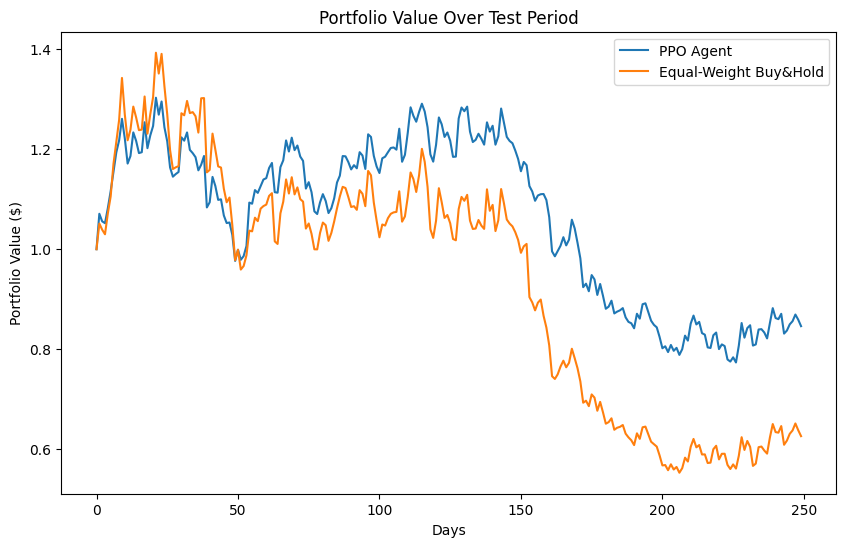

In [269]:
plt.figure(figsize=(10,6))
plt.plot(best_vals, label="PPO Agent")
plt.plot(baseline_history, label="Equal-Weight Buy&Hold")
plt.title("Portfolio Value Over Test Period")
plt.xlabel("Days")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.show()

In [270]:
def evaluate_baseline(price_array):
    days = price_array.shape[0]
    baseline_value = 1.0
    baseline_weights = [1.0 / num_assets] * num_assets  # equal weights on assets
    baseline_shares = [baseline_weights[i] * baseline_value / price_array[0][i] for i in range(num_assets)]
    # Assuming no rebalancing, simulate value appreciation over time
    for t in range(days - 1):
        baseline_portfolio_val = 0.0
        for k in range(num_assets):
            baseline_portfolio_val += baseline_shares[k] * price_array[t+1][k]
        baseline_value = baseline_portfolio_val
    baseline_return = (baseline_value - 1.0) * 100.0
    return baseline_value, baseline_return

In [271]:
baseline_value, baseline_return = evaluate_baseline(test_prices)
print(f"Baseline final value: ${baseline_val:.4f}  (Return: {baseline_return:.2f}%)")

Baseline final value: $0.6263  (Return: -37.37%)
